In [7]:
from visualise import visualise_v_stream, visualise_v_quiver
from dfNN import dfNN_for_vmap, PINN_backbone
from simulate import simulate_convergence, simulate_branching, simulate_ridge, simulate_merge, simulate_deflection
from metrics import compute_RMSE, compute_MAE

import torch
import torch.nn as nn
from torch.func import vmap, jacfwd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load training data

In [8]:
x_train = torch.load("data/sim_data/x_train_lines_discretised.pt").float()
y_train = simulate_convergence(x_train)

# small data
print(f"The shape of the training inputs is {x_train.shape}.")
print(f"The shape of the training observations is {y_train.shape}.")
print()
print(f"The dtype of the training inputs is {x_train.dtype}.")

The shape of the training inputs is torch.Size([196, 2]).
The shape of the training observations is torch.Size([196, 2]).

The dtype of the training inputs is torch.float32.


In [36]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
dfNN_model = dfNN_for_vmap()
dfNN_model.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(dfNN_model.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 1000

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(dfNN_model)(x_batch)

        # Compute loss (RMSE for same units as data)
        loss = torch.sqrt(criterion(y_pred, y_batch))
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE): {loss.item():.4f}")


Start Training
Epoch 1/1000, Training Loss (RMSE): 1.4139
Epoch 2/1000, Training Loss (RMSE): 1.4874
Epoch 3/1000, Training Loss (RMSE): 1.6946
Epoch 4/1000, Training Loss (RMSE): 1.3461
Epoch 5/1000, Training Loss (RMSE): 1.8738
Epoch 6/1000, Training Loss (RMSE): 1.2724
Epoch 7/1000, Training Loss (RMSE): 1.5555
Epoch 8/1000, Training Loss (RMSE): 1.5727
Epoch 9/1000, Training Loss (RMSE): 1.8421
Epoch 10/1000, Training Loss (RMSE): 1.2401
Epoch 11/1000, Training Loss (RMSE): 1.8426
Epoch 12/1000, Training Loss (RMSE): 0.9858
Epoch 13/1000, Training Loss (RMSE): 1.4637
Epoch 14/1000, Training Loss (RMSE): 1.8061
Epoch 15/1000, Training Loss (RMSE): 1.4814
Epoch 16/1000, Training Loss (RMSE): 1.1281
Epoch 17/1000, Training Loss (RMSE): 1.4294
Epoch 18/1000, Training Loss (RMSE): 1.1959
Epoch 19/1000, Training Loss (RMSE): 1.3658
Epoch 20/1000, Training Loss (RMSE): 1.4809
Epoch 21/1000, Training Loss (RMSE): 1.1479
Epoch 22/1000, Training Loss (RMSE): 1.7233
Epoch 23/1000, Training L

In [38]:
# Generate rather dense grid for eval
side = torch.linspace(start = 0., end = 3., steps = 50)
XX, YY = torch.meshgrid(side, side, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
x_test = x_test_grid.reshape(-1, 2)

# Retrieve true
y_test = simulate_convergence(x_test)

In [39]:
dfNN_model.eval()
# Pass through
y_train_dfNN_predicted = vmap(dfNN_model)(x_train)
y_test_dfNN_predicted = vmap(dfNN_model)(x_test)

# Divergence
dfNN_train_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_train), dim1 = -2, dim2 = -1).detach().sum().item()
dfNN_test_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_test), dim1 = -2, dim2 = -1).detach().sum().item()

# Train
dfNN_train_RMSE = compute_RMSE(y_train, y_train_dfNN_predicted)
print(f"dfNN Train RMSE: {dfNN_train_RMSE:.4f}")
dfNN_train_MAE = compute_MAE(y_train , y_train_dfNN_predicted)
print(f"dfNN Train MAE: {dfNN_train_MAE:.4f}")
print(f"dfNN Train Divergence: {dfNN_train_div:.4f}")

# Test
print("")
dfNN_test_RMSE = compute_RMSE(y_test, y_test_dfNN_predicted)
print(f"dfNN Test RMSE: {dfNN_test_RMSE:.4f}")
dfNN_test_MAE = compute_MAE(y_test, y_test_dfNN_predicted)
print(f"dfNN Test MAE: {dfNN_test_MAE:.4f}")
print(f"dfNN Test Divergence: {dfNN_test_div:.4f}")

dfNN Train RMSE: 0.3914
dfNN Train MAE: 0.2975
dfNN Train Divergence: 0.0000

dfNN Test RMSE: 0.4590
dfNN Test MAE: 0.3590
dfNN Test Divergence: 0.0000


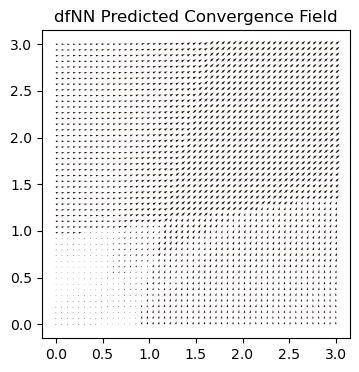

In [13]:
visualise_v_quiver(y_test_dfNN_predicted.detach(), x_test.detach(), title_string = "dfNN Predicted Convergence Field") # order is v, x

# PINN

In [22]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# equal weighting in loss
w = 0.5

# Initialise fresh model
PINN_model = PINN_backbone()
PINN_model.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(PINN_model.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 1000

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(PINN_model)(x_batch)
        # torch.Size([32 (batch_dim), 2 (out_dim), 2 (in_dim)])
        batch_divergence = vmap(jacfwd(PINN_model))(x_batch)
        # sum: f1/x1 + f2/x2, square to account for negative
        batch_divergence_loss = torch.square(torch.diagonal(batch_divergence, dim1 = -2, dim2 = -1).sum())

        # Compute loss (RMSE for same units as data) + divergence loss
        loss = (1 - w) * torch.sqrt(criterion(y_pred, y_batch)) + w * batch_divergence_loss
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE + divergence loss): {loss.item():.4f}")


Start Training
Epoch 1/1000, Training Loss (RMSE + divergence loss): 0.8506
Epoch 2/1000, Training Loss (RMSE + divergence loss): 1.0498
Epoch 3/1000, Training Loss (RMSE + divergence loss): 0.9593
Epoch 4/1000, Training Loss (RMSE + divergence loss): 0.4241
Epoch 5/1000, Training Loss (RMSE + divergence loss): 0.8147
Epoch 6/1000, Training Loss (RMSE + divergence loss): 0.9914
Epoch 7/1000, Training Loss (RMSE + divergence loss): 1.0947
Epoch 8/1000, Training Loss (RMSE + divergence loss): 0.9182
Epoch 9/1000, Training Loss (RMSE + divergence loss): 0.9470
Epoch 10/1000, Training Loss (RMSE + divergence loss): 0.8095
Epoch 11/1000, Training Loss (RMSE + divergence loss): 0.8897
Epoch 12/1000, Training Loss (RMSE + divergence loss): 0.9533
Epoch 13/1000, Training Loss (RMSE + divergence loss): 0.5812
Epoch 14/1000, Training Loss (RMSE + divergence loss): 0.8309
Epoch 15/1000, Training Loss (RMSE + divergence loss): 0.4549
Epoch 16/1000, Training Loss (RMSE + divergence loss): 0.5787
E

In [ ]:
PINN_model.eval()
# Pass through
y_train_PINN_predicted = vmap(PINN_model)(x_train)
y_test_PINN_predicted = vmap(PINN_model)(x_test)

# Divergence
PINN_train_div = torch.diagonal(vmap(jacfwd(PINN_model))(x_train), dim1 = -2, dim2 = -1).detach().sum().item()
PINN_test_div = torch.diagonal(vmap(jacfwd(PINN_model))(x_test), dim1 = -2, dim2 = -1).detach().sum().item()

# Train
PINN_train_RMSE = compute_RMSE(y_train, y_train_PINN_predicted)
print(f"PINN Train RMSE: {PINN_train_RMSE:.4f}")
PINN_train_MAE = compute_MAE(y_train , y_train_PINN_predicted)
print(f"PINN Train MAE: {PINN_train_MAE:.4f}")
print(f"PINN Train Divergence: {PINN_train_div:.4f}")

# Test
print("")
PINN_test_RMSE = compute_RMSE(y_test, y_test_PINN_predicted)
print(f"PINN Test RMSE: {PINN_test_RMSE:.4f}")
PINN_test_MAE = compute_MAE(y_test, y_test_PINN_predicted)
print(f"PINN Test MAE: {PINN_test_MAE:.4f}")
print(f"PINN Test Divergence: {PINN_test_div:.4f}")

PINN Train RMSE: 0.4812
PINN Train MAE: 0.4015
PINN Train Divergence: -0.3516

PINN Test RMSE: 0.5067
PINN Test MAE: 0.4094
PINN Test Divergence: -43.0912
